# Best time for holiday
Eemärk analüüsida meteo.physic.ut.ee arhiivi andmeid ja leid parima ilmaga aeg puhkuse jaoks. 
Ette antaks puhkuse pikkus päevades. Programm leiab kalendrist ajad, mil sellise perioodi kestel on ajalooliselt olnud kõrgeim keskmine temperatuur, vähim sademeid jne. Võrrelda saaks nii ajaloolist keskmist, kui ka kõiki varasemaid aastaid eraldi.
<hr>
The aim is to find warmest and dryest time for holiday through analyseing historical weather data. Project is built on data from Tartu University wether station (http://meteo.physic.ut.ee) but also other data sources can be used.
<br>
The length of holiday must be defined (number of days).

You can start from here if you would like to skip data acq. and first prep <br>
[Another Cell](#parttime1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as datetime
import seaborn as sns
import os
import psutil
import numpy as np


Data can be acquired from here: http://meteo.physic.ut.ee/en/archive.php?do=data&begin%5Byear%5D=2018&begin%5Bmon%5D=9&begin%5Bmday%5D=1&end%5Byear%5D=2018&end%5Bmon%5D=9&end%5Bmday%5D=14&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Query+

It seems that meteo server is not acepting longer periods than 12 months. Step-by-step query is needed.



# Getting data 

In [3]:
# get current date and time
moment=datetime.datetime.now()
#print(moment.year, moment.month, moment.day)
#print(moment.hour, moment.minute, moment.second)
print('moment: ',moment)
#and take one day from now
endtime=moment+datetime.timedelta(days=1)
print('endtime:',endtime)

moment:  2018-12-17 20:29:42.048988
endtime: 2018-12-18 20:29:42.048988


In [4]:
%%time
# testing if there is a local data cache file availabele
# and reading it
# get the latest timepoint from the file
# if there is no local cache available, set the starttime to 1999-1-1

#import os
failinimed=os.listdir()
if 'datacache.pkl' not in failinimed:
    starttime=datetime.datetime(1999, 1,1)
    data=pd.DataFrame()
else:
    data=pd.read_pickle('datacache.pkl', compression='gzip')
    starttime=data.index[-1]
print('Data points: \n', data.count())
print('Last datapoint:', starttime)

Data points: 
  Temperature          1972593
 Humidity             1972593
 Air pressure         1972593
 Wind speed           1972593
 Wind direction       1972593
 Precipitation        1972593
 UV index             1972593
 Light                1972593
 Irradiation flux     1972593
 Gamma radiation      1972593
 Snowfall estimate    1972593
dtype: int64
Last datapoint: 2018-12-17 11:35:00
Wall time: 6.63 s


In [5]:
#starttime=data.index[-1]
print('Last datapoint:', starttime)

Last datapoint: 2018-12-17 11:35:00


In [6]:
#url2='http://meteo.physic.ut.ee/en/archive.php?do=data&begin%5Byear%5D={0}&begin%5Bmon%5D={1}&begin%5Bmday%5D={2}&end%5Byear%5D={3}&end%5Bmon%5D={4}&end%5Bmday%5D={5}&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Query+'.format(starttime.year, starttime.month, starttime.day, endtime.year, endtime.month, endtime.day)
#print(url2)

In [7]:
writeneeded=False

In [8]:
%%time
# Meteo server is not accepting querys for much longer period than one year. So we get the data by fragments...
def meteoquery(strt,endt):
    print('Getting:', strt, '->', endt)
    url='http://meteo.physic.ut.ee/en/archive.php?do=data&begin%5Byear%5D={0}&begin%5Bmon%5D={1}&begin%5Bmday%5D={2}&end%5Byear%5D={3}&end%5Bmon%5D={4}&end%5Bmday%5D={5}&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Query+'.format(strt.year, strt.month, strt.day, endt.year, endt.month, endt.day)
#    print(url)
    result=pd.read_csv(url,parse_dates=['Times'], index_col='Times', engine='python')
    return result

starttime=data.index[-1]
moment=datetime.datetime.now()
while starttime+datetime.timedelta(days=360)<moment:
    endtime=starttime+datetime.timedelta(days=360)
#    print(starttime, '->', endtime)
#    url='http://meteo.physic.ut.ee/en/archive.php?do=data&begin%5Byear%5D={0}&begin%5Bmon%5D={1}&begin%5Bmday%5D={2}&end%5Byear%5D={3}&end%5Bmon%5D={4}&end%5Bmday%5D={5}&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Query+'.format(starttime.year, starttime.month, starttime.day, endtime.year, endtime.month, endtime.day)
#    print(url)
#    data1=pd.read_csv(url,parse_dates=['Times'], index_col='Times', engine='python')
#    data=pd.concat([data, data1]).drop_duplicates()
    data=pd.concat([data, meteoquery(starttime, endtime)]).drop_duplicates()
    writeneeded=True
    starttime=endtime
if ((moment-starttime).total_seconds()/(60*60)) > 2: #no new querys to the server if last measurement is newer than # hours.
    endtime=moment+datetime.timedelta(days=1)
#    print(starttime, '-->', endtime, '=', endtime-starttime)
#    url='http://meteo.physic.ut.ee/en/archive.php?do=data&begin%5Byear%5D={0}&begin%5Bmon%5D={1}&begin%5Bmday%5D={2}&end%5Byear%5D={3}&end%5Bmon%5D={4}&end%5Bmday%5D={5}&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Query+'.format(starttime.year, starttime.month, starttime.day, endtime.year, endtime.month, endtime.day)
#    print(url)
#    data1=pd.read_csv(url,parse_dates=['Times'], index_col='Times', engine='python')
#    data=pd.concat([data, data1]).drop_duplicates()
    data=pd.concat([data, meteoquery(starttime, endtime)]).drop_duplicates()
    writeneeded=True

Getting: 2018-12-17 11:35:00 -> 2018-12-18 20:30:17.473507
Wall time: 9.89 s


Originally toke 1min 27s do download raw data from Meteo server

In [9]:
%%time
# writing data to local cache file datacache.pkl
if writeneeded:
    data.to_pickle('datacache.pkl', compression='gzip')
    writeneeded=False

Wall time: 1min 16s


55.8 sec to save it to the pickle file compressed with gzip
<br>file size is 65.7 MB compressed. 66 MB on 4. oct. 2018.
<br> with MacBookAir late 2011 1min 17s

# Inspecting data

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972699 entries, 1999-11-01 00:00:00 to 2018-12-17 20:25:00
Data columns (total 11 columns):
 Temperature          object
 Humidity             object
 Air pressure         object
 Wind speed           object
 Wind direction       object
 Precipitation        object
 UV index             object
 Light                object
 Irradiation flux     object
 Gamma radiation      object
 Snowfall estimate    object
dtypes: object(11)
memory usage: 180.6+ MB


In [11]:
print('Datapoints: ', len(data))
print('First datapoint:', data.index[0])
print('Last datapoint: ', data.index[-1])

Datapoints:  1972699
First datapoint: 1999-11-01 00:00:00
Last datapoint:  2018-12-17 20:25:00


# Correcting dataframe structure

In [12]:
data.columns.tolist()

[' Temperature',
 ' Humidity',
 ' Air pressure',
 ' Wind speed',
 ' Wind direction',
 ' Precipitation',
 ' UV index',
 ' Light',
 ' Irradiation flux',
 ' Gamma radiation',
 ' Snowfall estimate']

In [47]:
#removing unnessesary spaces
data.columns=data.columns.str.strip().str.replace(' ','_')

In [48]:
data.columns.tolist()

['Temperature',
 'Humidity',
 'Air_pressure',
 'Wind_speed',
 'Wind_direction',
 'Precipitation',
 'UV_index',
 'Light',
 'Irradiation_flux',
 'Gamma_radiation',
 'Snowfall_estimate']

In [18]:
for index, tulp in enumerate(data.columns):
    print(index, '-', tulp)
    #print(tulp.replace(' ',''))
    #print(tulp.strip())

0 - Temperature
1 - Humidity
2 - Air_pressure
3 - Wind_speed
4 - Wind_direction
5 - Precipitation
6 - UV_index
7 - Light
8 - Irradiation_flux
9 - Gamma_radiation
10 - Snowfall_estimate


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972593 entries, 1999-11-01 00:00:00 to 2018-12-17 11:35:00
Data columns (total 11 columns):
Temperature          object
Humidity             object
Air_pressure         object
Wind_speed           object
Wind_direction       object
Precipitation        object
UV_index             object
Light                object
Irradiation_flux     object
Gamma_radiation      object
Snowfall_estimate    object
dtypes: object(11)
memory usage: 180.6+ MB


In [20]:
pd.concat([data.head(),data.tail()])

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
1999-11-01 00:00:00,6.6,,1001.7,1.1,227,,,0,,0.092,
1999-11-01 00:05:00,6.6,,1001.5,1.2,230,,,0,,0.09,
1999-11-01 00:10:00,6.5,,1001.2,0.5,203,,,0,,0.103,
1999-11-01 00:15:00,6.6,,1001.6,0.8,223,,,0,,0.063,
1999-11-01 00:20:00,6.6,,1001.7,1.3,243,,,0,,0.101,
2018-12-17 11:15:00,-3.04428,92.7646,1025.55,2.71432,153.386,0,,,46.8439,,0
2018-12-17 11:20:00,-3.04332,92.589,1025.56,2.0608,160.042,0,,,46.8005,,0
2018-12-17 11:25:00,-3.0252,92.5188,1025.57,2.48707,154.657,0,,,46.6599,,0
2018-12-17 11:30:00,-2.93717,92.5552,1025.56,1.77842,156.014,0.071,,,43.9932,,0.9


In [21]:
data.columns

Index(['Temperature', 'Humidity', 'Air_pressure', 'Wind_speed',
       'Wind_direction', 'Precipitation', 'UV_index', 'Light',
       'Irradiation_flux', 'Gamma_radiation', 'Snowfall_estimate'],
      dtype='object')

Changeing data types to float

In [22]:
%%time
for element in data.columns:
    print(element)
    data[element]=pd.to_numeric(data[element],errors='coerce')

Temperature
Humidity
Air_pressure
Wind_speed
Wind_direction
Precipitation
UV_index
Light
Irradiation_flux
Gamma_radiation
Snowfall_estimate
Wall time: 11.1 s


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972593 entries, 1999-11-01 00:00:00 to 2018-12-17 11:35:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 180.6 MB


In [24]:
pd.concat([data.head(), data.tail()])

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
1999-11-01 00:00:00,6.600000,NaN,1001.700000,1.100000,227.000000,NaN,NaN,0.0,NaN,0.092,NaN
1999-11-01 00:05:00,6.600000,NaN,1001.500000,1.200000,230.000000,NaN,NaN,0.0,NaN,0.090,NaN
1999-11-01 00:10:00,6.500000,NaN,1001.200000,0.500000,203.000000,NaN,NaN,0.0,NaN,0.103,NaN
1999-11-01 00:15:00,6.600000,NaN,1001.600000,0.800000,223.000000,NaN,NaN,0.0,NaN,0.063,NaN
1999-11-01 00:20:00,6.600000,NaN,1001.700000,1.300000,243.000000,NaN,NaN,0.0,NaN,0.101,NaN
2018-12-17 11:15:00,-3.044283,92.764574,1025.547467,2.714323,153.385546,0.000,NaN,NaN,46.843942,NaN,0.0
2018-12-17 11:20:00,-3.043318,92.588976,1025.562700,2.060799,160.041953,0.000,NaN,NaN,46.800469,NaN,0.0
2018-12-17 11:25:00,-3.025200,92.518778,1025.571733,2.487066,154.657111,0.000,NaN,NaN,46.659936,NaN,0.0
2018-12-17 11:30:00,-2.937171,92.555189,1025.563700,1.778424,156.013523,0.071,NaN,NaN,43.993221,NaN,0.9


In [25]:
data.describe()

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
count,1.969787e+06,1.791039e+06,1.915373e+06,1.548235e+06,1.493091e+06,1.700937e+06,288481.000000,1.374432e+06,1.046010e+06,1.509583e+06,1.698461e+06
mean,6.590999e+00,7.824779e+01,1.007645e+03,2.656547e+00,1.910529e+02,4.066420e-03,1.533479,9.517597e+03,1.191993e+02,9.808723e-02,3.779363e-03
std,9.474377e+00,1.948211e+01,1.151553e+01,1.763306e+00,9.007379e+01,4.772784e-02,4.398442,1.963957e+04,2.218343e+02,1.672303e-02,1.061345e-01
min,-1.318409e+02,-1.583138e+00,8.115000e+02,0.000000e+00,0.000000e+00,-8.400000e+00,0.000064,-2.962994e+04,-4.366599e+01,-3.288218e-02,-6.800000e+00
25%,1.000000e-01,6.599338e+01,1.000600e+03,1.400000e+00,1.240000e+02,0.000000e+00,0.134925,4.380000e+02,1.656628e+00,8.771386e-02,0.000000e+00
50%,6.242258e+00,8.344961e+01,1.007700e+03,2.452718e+00,2.023493e+02,0.000000e+00,0.627143,1.965451e+03,5.173155e+00,9.671618e-02,0.000000e+00
75%,1.404310e+01,9.414103e+01,1.014842e+03,3.658664e+00,2.650000e+02,0.000000e+00,1.519061,8.681000e+03,1.230000e+02,1.070000e-01,0.000000e+00
max,3.370000e+01,1.209572e+02,1.054122e+03,5.105643e+01,3.600000e+02,9.799000e+00,54.125747,3.747921e+05,1.998000e+03,2.440000e-01,1.930000e+01


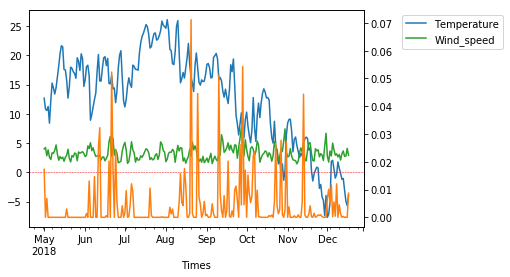

In [26]:
ax=data['2018-5':][['Temperature','Precipitation','Wind_speed']].resample('D').mean().plot(secondary_y=['Precipitation']);
ax.legend(loc='upper left', bbox_to_anchor=(1.1,1));
#ax=data['2018-10-3']['Temperature'].plot()
#data['2018-10-3']['Precipitation'].dropna().plot(secondary_y='Precipitation', ax=ax)
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5);

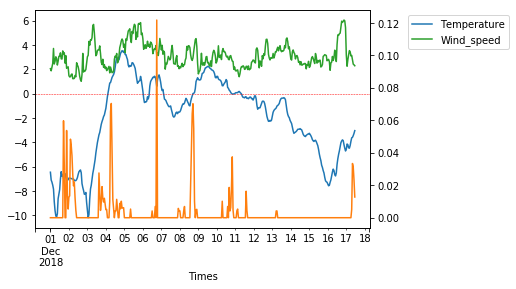

In [27]:
ax=data['2018-12':][['Temperature','Precipitation','Wind_speed']].resample('H').mean().plot(secondary_y=['Precipitation']);
ax.legend(loc='upper left', bbox_to_anchor=(1.1,1));
#ax=data['2018-10-3']['Temperature'].plot()
#data['2018-10-3']['Precipitation'].dropna().plot(secondary_y='Precipitation', ax=ax)
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5);

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972593 entries, 1999-11-01 00:00:00 to 2018-12-17 11:35:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 260.6 MB


In [29]:
%%time
# Save preprocessed data to file
data.to_pickle("data.pkl")

Wall time: 930 ms


<a id='parttime1'></a>
<hr>

## ---- Work can be continued from here ------
Reading preprocessed data from file data.pkl


In [2]:
#Prerequisits (needed if started from this point)
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as datetime
import seaborn as sns
import os
import psutil
import numpy as np

In [40]:
%%time
data=pd.read_pickle("data.pkl")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972593 entries, 1999-11-01 00:00:00 to 2018-12-17 11:35:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 180.6 MB
Wall time: 345 ms


## Continueing only with temperature data

In [30]:
#import os
#import psutil
process = psutil.Process(os.getpid())
print(process.name(),':',process.memory_info().rss/1024/1024,'MB RAM usage')

python.exe : 374.6015625 MB RAM usage


In [31]:
data.drop(data.columns[1:], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972593 entries, 1999-11-01 00:00:00 to 2018-12-17 11:35:00
Data columns (total 1 columns):
Temperature    float64
dtypes: float64(1)
memory usage: 110.1 MB


In [32]:
process = psutil.Process(os.getpid())
print(process.name(),':',process.memory_info().rss/1024/1024,'MB RAM usage')

python.exe : 224.10546875 MB RAM usage


In [33]:
%%time
# add column called Pseudo_date for easier data grouping and plotting
data['Pseudo_date']=data.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
data['Year']=data.index.year
data['Month']=data.index.month
data['Day']=data.index.day

Wall time: 46.3 s


In [34]:
process = psutil.Process(os.getpid())
print(process.name(),':',process.memory_info().rss/1024/1024,'MB RAM usage')

python.exe : 286.3515625 MB RAM usage


In [35]:
pd.concat([data.head(), data.tail()])

,Temperature,Pseudo_date,Year,Month,Day
Times,,,,,
1999-11-01 00:00:00,6.600000,1904-11-01 00:00:00,1999,11,1
1999-11-01 00:05:00,6.600000,1904-11-01 00:00:00,1999,11,1
1999-11-01 00:10:00,6.500000,1904-11-01 00:00:00,1999,11,1
1999-11-01 00:15:00,6.600000,1904-11-01 00:00:00,1999,11,1
1999-11-01 00:20:00,6.600000,1904-11-01 00:00:00,1999,11,1
2018-12-17 11:15:00,-3.044283,1904-12-17 11:00:00,2018,12,17
2018-12-17 11:20:00,-3.043318,1904-12-17 11:00:00,2018,12,17
2018-12-17 11:25:00,-3.025200,1904-12-17 11:00:00,2018,12,17
2018-12-17 11:30:00,-2.937171,1904-12-17 11:00:00,2018,12,17


# Data cleaning
Cleaning up nonsens data

In [45]:
data.describe()

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
count,1969787.0000,1791039.0000,1915373.0000,1548235.0000,1493091.0000,1700937.0000,288481.0000,1374432.0000,1046010.0000,1509583.0000,1698461.0000
mean,6.5910,78.2478,1007.6452,2.6565,191.0529,0.0041,1.5335,9517.5968,119.1993,0.0981,0.0038
std,9.4744,19.4821,11.5155,1.7633,90.0738,0.0477,4.3984,19639.5699,221.8343,0.0167,0.1061
min,-131.8409,-1.5831,811.5000,0.0000,0.0000,-8.4000,0.0001,-29629.9438,-43.6660,-0.0329,-6.8000
25%,0.1000,65.9934,1000.6000,1.4000,124.0000,0.0000,0.1349,438.0000,1.6566,0.0877,0.0000
50%,6.2423,83.4496,1007.7000,2.4527,202.3493,0.0000,0.6271,1965.4513,5.1732,0.0967,0.0000
75%,14.0431,94.1410,1014.8424,3.6587,265.0000,0.0000,1.5191,8681.0000,123.0000,0.1070,0.0000
max,33.7000,120.9572,1054.1222,51.0564,360.0000,9.7990,54.1257,374792.0898,1998.0000,0.2440,19.3000


In [67]:
data.Temperature.describe()

count   1969787.0000
mean          6.5910
std           9.4744
min        -131.8409
25%           0.1000
50%           6.2423
75%          14.0431
max          33.7000
Name: Temperature, dtype: float64

In [76]:
data.columns.tolist()

['Temperature',
 'Humidity',
 'Air_pressure',
 'Wind_speed',
 'Wind_direction',
 'Precipitation',
 'UV_index',
 'Light',
 'Irradiation_flux',
 'Gamma_radiation',
 'Snowfall_estimate']

In [96]:
distmax={'Temperature':0.05,
 'Humidity':0.05,
 'Air_pressure':0.04,
 'Wind_speed':0.25,
 'Wind_direction':0.005,
 'Precipitation':3,
 'UV_index':0.6,
 'Light':0.0002,
 'Irradiation_flux':0.035,
 'Gamma_radiation':25,
 'Snowfall_estimate':5}


Temperature :
count   1969787.0000
mean          6.5910
std           9.4744
min        -131.8409
25%           0.1000
50%           6.2423
75%          14.0431
max          33.7000
Name: Temperature, dtype: float64


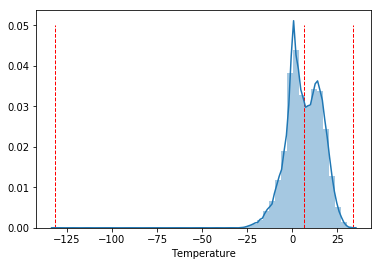

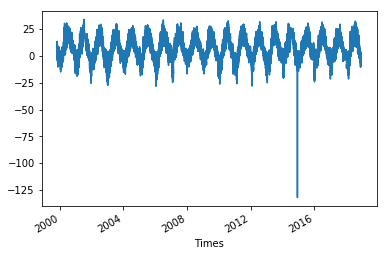

___________
Humidity :
count   1791039.0000
mean         78.2478
std          19.4821
min          -1.5831
25%          65.9934
50%          83.4496
75%          94.1410
max         120.9572
Name: Humidity, dtype: float64


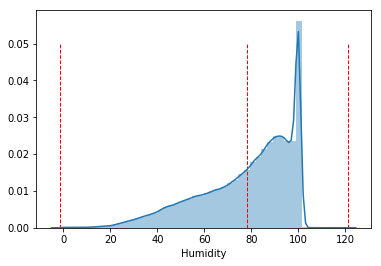

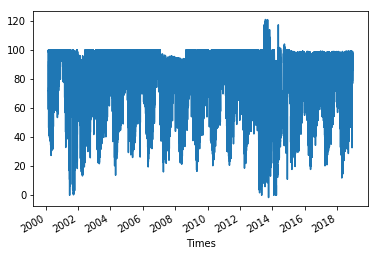

___________
Air_pressure :
count   1915373.0000
mean       1007.6452
std          11.5155
min         811.5000
25%        1000.6000
50%        1007.7000
75%        1014.8424
max        1054.1222
Name: Air_pressure, dtype: float64


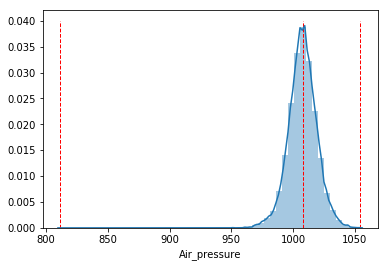

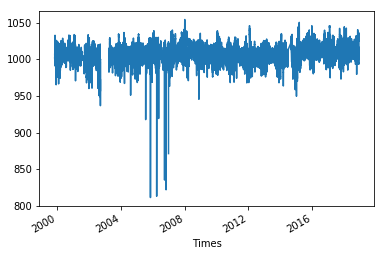

___________
Wind_speed :
count   1548235.0000
mean          2.6565
std           1.7633
min           0.0000
25%           1.4000
50%           2.4527
75%           3.6587
max          51.0564
Name: Wind_speed, dtype: float64


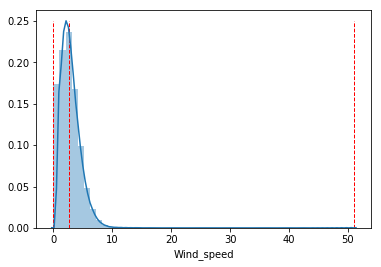

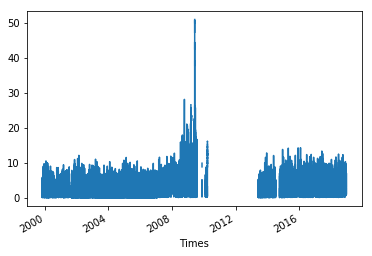

___________
Wind_direction :
count   1493091.0000
mean        191.0529
std          90.0738
min           0.0000
25%         124.0000
50%         202.3493
75%         265.0000
max         360.0000
Name: Wind_direction, dtype: float64


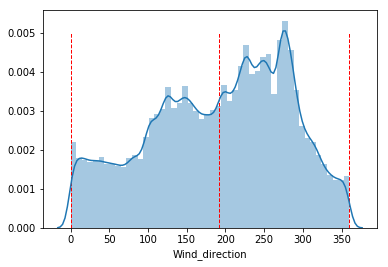

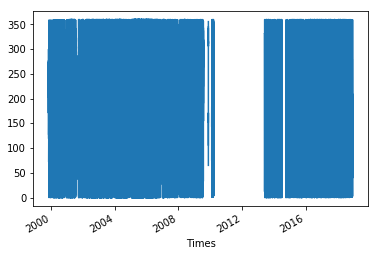

___________
Precipitation :
count   1700937.0000
mean          0.0041
std           0.0477
min          -8.4000
25%           0.0000
50%           0.0000
75%           0.0000
max           9.7990
Name: Precipitation, dtype: float64


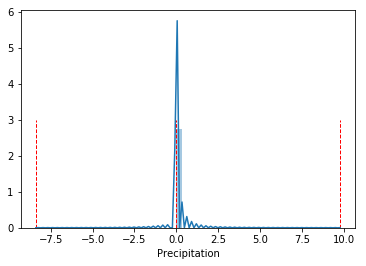

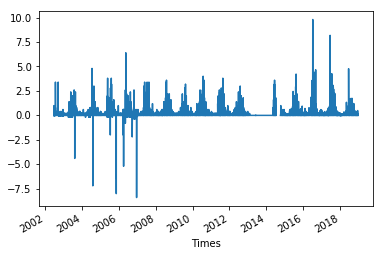

___________
UV_index :
count   288481.0000
mean         1.5335
std          4.3984
min          0.0001
25%          0.1349
50%          0.6271
75%          1.5191
max         54.1257
Name: UV_index, dtype: float64


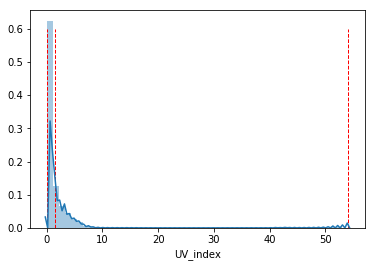

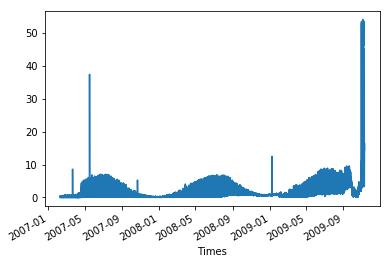

___________
Light :
count   1374432.0000
mean       9517.5968
std       19639.5699
min      -29629.9438
25%         438.0000
50%        1965.4513
75%        8681.0000
max      374792.0898
Name: Light, dtype: float64


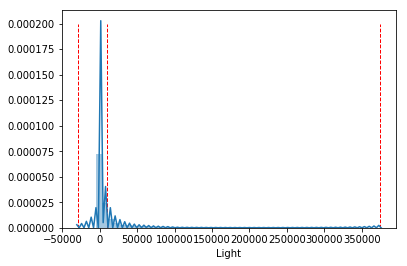

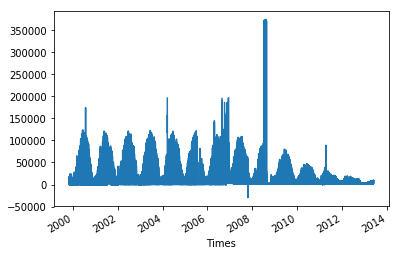

___________
Irradiation_flux :
count   1046010.0000
mean        119.1993
std         221.8343
min         -43.6660
25%           1.6566
50%           5.1732
75%         123.0000
max        1998.0000
Name: Irradiation_flux, dtype: float64


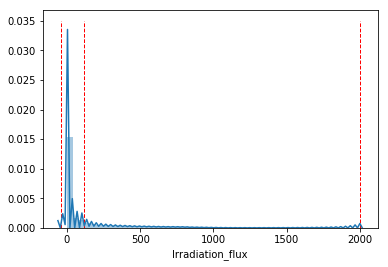

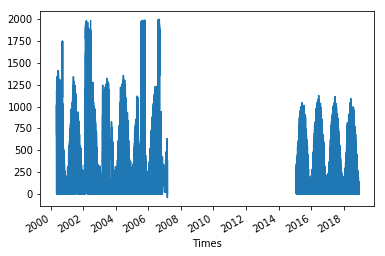

___________
Gamma_radiation :
count   1509583.0000
mean          0.0981
std           0.0167
min          -0.0329
25%           0.0877
50%           0.0967
75%           0.1070
max           0.2440
Name: Gamma_radiation, dtype: float64


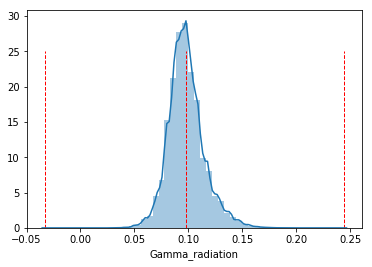

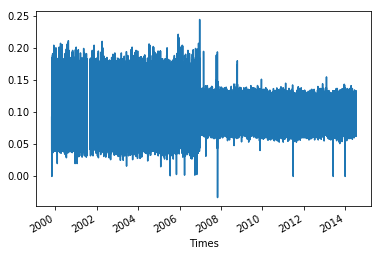

___________
Snowfall_estimate :
count   1698461.0000
mean          0.0038
std           0.1061
min          -6.8000
25%           0.0000
50%           0.0000
75%           0.0000
max          19.3000
Name: Snowfall_estimate, dtype: float64


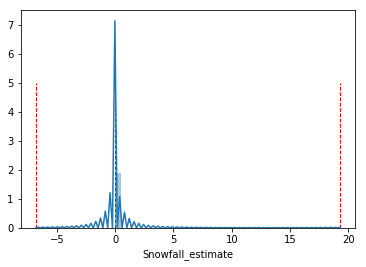

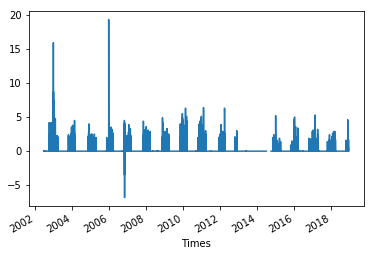

___________


In [97]:
for element in data.columns:
#    print(element, 'min:', data[element].min(), 'max:', data[element].max())
    print(element,':')
    print(data[element].describe())
    ax=sns.distplot(data[element].dropna());
    ax.vlines([data[element].min(), data[element].max(), data[element].mean()], 0, distmax[element],linewidth=1, linestyle='--', color='red')
    plt.show()
    data[element].plot()
    plt.show()
    print('___________')

In [161]:
element='Snowfall_estimate'
print(element,':')
print(data[element].describe())
ax=sns.distplot(data[element].dropna());
ax.vlines([data[element].min(), data[element].max(), data[element].mean()], 0, distmax[element],linewidth=1, linestyle='--', color='red')
#plt.show()
#data[element].plot()
#plt.show()
print('___________')

Snowfall_estimate :
count   1698461.0000
mean          0.0038
std           0.1061
min          -6.8000
25%           0.0000
50%           0.0000
75%           0.0000
max          19.3000
Name: Snowfall_estimate, dtype: float64
___________


In [163]:
data[element].nsmallest(50)

Times
2006-11-05 12:55:00   -6.8000
2006-11-05 09:10:00   -4.1000
2006-11-05 07:10:00   -4.0000
2006-11-05 07:55:00   -4.0000
2006-11-05 08:05:00   -4.0000
2006-11-05 06:35:00   -3.9000
2006-11-05 06:45:00   -3.9000
2006-11-05 10:05:00   -3.8000
2006-11-04 06:25:00   -3.7000
2006-11-04 06:45:00   -3.7000
2006-11-04 07:20:00   -3.7000
2006-11-04 07:40:00   -3.7000
2006-11-04 08:05:00   -3.7000
2006-11-05 04:30:00   -3.7000
2006-11-05 04:40:00   -3.7000
2006-11-05 04:50:00   -3.7000
2006-11-05 05:25:00   -3.7000
2006-11-05 05:35:00   -3.7000
2006-11-05 05:55:00   -3.7000
2006-11-05 06:15:00   -3.7000
2006-11-05 10:15:00   -3.7000
2006-11-05 12:15:00   -3.7000
2006-11-04 08:20:00   -3.6000
2006-11-04 08:35:00   -3.6000
2006-11-04 08:50:00   -3.6000
2006-11-05 02:05:00   -3.6000
2006-11-05 03:55:00   -3.6000
2006-11-05 04:15:00   -3.6000
2006-11-05 05:10:00   -3.6000
2006-11-05 11:50:00   -3.6000
2006-11-05 12:35:00   -3.6000
2006-11-04 05:30:00   -3.5000
2006-11-04 05:45:00   -3.5000
2006

In [166]:
data[element][data[element]<0].nsmallest(50)

Times
2006-11-05 12:55:00   -6.8000
2006-11-05 09:10:00   -4.1000
2006-11-05 07:10:00   -4.0000
2006-11-05 07:55:00   -4.0000
2006-11-05 08:05:00   -4.0000
2006-11-05 06:35:00   -3.9000
2006-11-05 06:45:00   -3.9000
2006-11-05 10:05:00   -3.8000
2006-11-04 06:25:00   -3.7000
2006-11-04 06:45:00   -3.7000
2006-11-04 07:20:00   -3.7000
2006-11-04 07:40:00   -3.7000
2006-11-04 08:05:00   -3.7000
2006-11-05 04:30:00   -3.7000
2006-11-05 04:40:00   -3.7000
2006-11-05 04:50:00   -3.7000
2006-11-05 05:25:00   -3.7000
2006-11-05 05:35:00   -3.7000
2006-11-05 05:55:00   -3.7000
2006-11-05 06:15:00   -3.7000
2006-11-05 10:15:00   -3.7000
2006-11-05 12:15:00   -3.7000
2006-11-04 08:20:00   -3.6000
2006-11-04 08:35:00   -3.6000
2006-11-04 08:50:00   -3.6000
2006-11-05 02:05:00   -3.6000
2006-11-05 03:55:00   -3.6000
2006-11-05 04:15:00   -3.6000
2006-11-05 05:10:00   -3.6000
2006-11-05 11:50:00   -3.6000
2006-11-05 12:35:00   -3.6000
2006-11-04 05:30:00   -3.5000
2006-11-04 05:45:00   -3.5000
2006

In [165]:
data[element].plot()


1. Temperatures (in Celsius) below -40 in year 2014 december is not realistic
***
2. Humidity (RH) over 100% and below 0% in not realistic. Even 0% seems to be unrealistic.
3. Air pressure is in [hPa]. Below 940 seems to be unrealistic!
4. Wind speed over 30 m/s seems to be unrealistic!
5. Wind direction seems to be OK
6. Precipitation below 0 is not real
7. UV index over 10, is it realistic? Probably no!
8. Light below 0 is not real. Also investigate the upper limit - over 350000, is it realistic? Proably no. Realistic maximum seems to be below 140000.
9. Irradiation_flux below 0 is not real? Over 1400 seems to be also suspicious. 
10. Gamma_radiation find out realistic values. Below 0 is not real - one reading. Is upper limit OK? 0.244
11. Snowfall_estimate below 0 and over 10, is it realistic? Two readings over 8.7 and 

### Temperatures

In [38]:
# Set numeric format to more easily readable
pd.options.display.float_format = '{:.4f}'.format

In [56]:
data.Temperature.describe()

count   1968877.0000
mean          6.5962
std           9.4734
min        -131.8409
25%           0.1000
50%           6.2537
75%          14.0493
max          33.7000
Name: Temperature, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


min: -131.840910289 max: 33.7


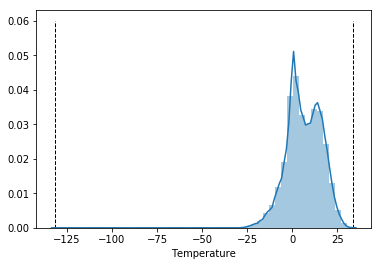

In [46]:
ax=sns.distplot(data.Temperature.dropna())
ax.vlines([data.Temperature.min(), data.Temperature.max()], 0, 0.06,linewidth=1, linestyle='--')
print('min:',data.Temperature.min(), 'max:',data.Temperature.max())

In [62]:
data.Temperature.nsmallest(10)

Times
2014-12-12 16:10:00   -131.8409
2014-12-12 16:15:00   -130.0620
2014-12-12 16:25:00    -97.8874
2014-12-12 16:05:00    -85.0415
2014-12-12 16:20:00    -73.8580
2014-12-12 16:30:00    -51.2103
2006-01-20 06:10:00    -28.4000
2006-01-20 06:15:00    -28.4000
2006-01-20 08:15:00    -28.4000
2006-01-20 08:35:00    -28.4000
Name: Temperature, dtype: float64

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1971683 entries, 1999-11-01 00:00:00 to 2018-12-14 07:45:00
Data columns (total 5 columns):
Temperature    float64
Pseudo_date    datetime64[ns]
Year           int64
Month          int64
Day            int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 90.3 MB


In [64]:
#dropping urealistic measeurements below -29 degrees Celsius
data.drop(data.loc[data.Temperature<-29].index, inplace=True)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1971677 entries, 1999-11-01 00:00:00 to 2018-12-14 07:45:00
Data columns (total 5 columns):
Temperature    float64
Pseudo_date    datetime64[ns]
Year           int64
Month          int64
Day            int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 90.3 MB


In [66]:

data.loc[data.Temperature.isnull()]

,Temperature,Pseudo_date,Year,Month,Day
Times,,,,,
1999-11-24 03:05:00,nan,1904-11-24 03:00:00,1999,11,24
1999-11-24 03:10:00,nan,1904-11-24 03:00:00,1999,11,24
1999-11-24 03:15:00,nan,1904-11-24 03:00:00,1999,11,24
1999-11-24 03:20:00,nan,1904-11-24 03:00:00,1999,11,24
1999-11-24 03:25:00,nan,1904-11-24 03:00:00,1999,11,24
1999-11-24 03:30:00,nan,1904-11-24 03:00:00,1999,11,24
1999-11-24 03:35:00,nan,1904-11-24 03:00:00,1999,11,24
1999-11-24 03:40:00,nan,1904-11-24 03:00:00,1999,11,24
1999-11-24 03:45:00,nan,1904-11-24 03:00:00,1999,11,24


In [67]:
# do I have to drop NaN values?
data.Temperature.dropna(inplace=True)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1971677 entries, 1999-11-01 00:00:00 to 2018-12-14 07:45:00
Data columns (total 5 columns):
Temperature    float64
Pseudo_date    datetime64[ns]
Year           int64
Month          int64
Day            int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 90.2 MB


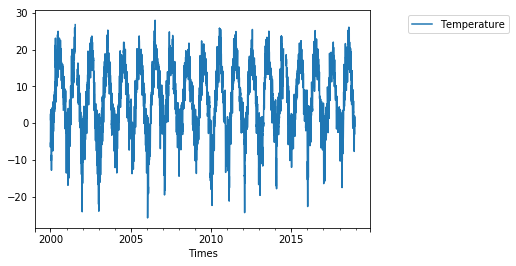

In [72]:
ax=data['2000-1':].Temperature.resample('D').mean().plot()
ax.legend(loc='upper left', bbox_to_anchor=(1.1,1))

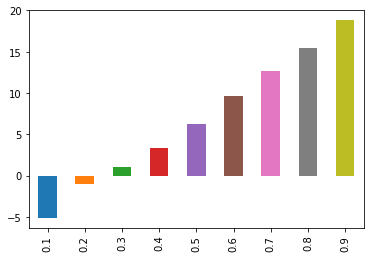

In [73]:
data.Temperature.quantile([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).plot(kind='bar')

min: -28.4 max: 33.7 mean: 6.596500812476477 median: 6.2537055837599995 mode: 0   0.0000
dtype: float64


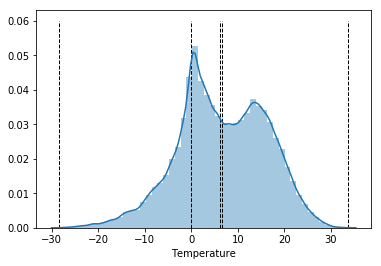

In [84]:
ax=sns.distplot(data.Temperature.dropna())
ax.vlines([data.Temperature.min(), data.Temperature.max(), data.Temperature.mean(), data.Temperature.median(), data.Temperature.mode()], 0, 0.06,linewidth=1, linestyle='--')
print('min:',data.Temperature.min(), 'max:',data.Temperature.max(),'mean:',data.Temperature.mean(), 'median:',data.Temperature.median(), 'mode:', data.Temperature.mode())

Võiks proovida ka CDF jaotust?
http://stanford.edu/~raejoon/blog/2017/05/16/python-recipes-for-cdfs.html
https://stackoverflow.com/questions/24575869/read-file-and-plot-cdf-in-python


Wall time: 5min 46s


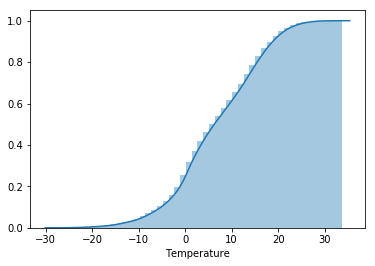

In [47]:
%%time
# You dont have to run this - it takes several minutes!
sns.distplot(data.Temperature.dropna(),
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

PC 1: Core i7 920 4-core/8-threads =6min 34s
<br>PC2: Core i5 4590 4-core/4-threads =5min 46s
<br>MacBookAir late 2011 i5 1.7 GHz 4GB RAM =7min 10s

### Precipitation
/not jet realized/

# Results ver. 1

In [101]:
data.tail()

,Temperature,Pseudo_date,Year,Month,Day
Times,,,,,
2018-12-14 07:25:00,-3.0654,1904-12-14 07:00:00,2018,12,14
2018-12-14 07:30:00,-3.0758,1904-12-14 07:00:00,2018,12,14
2018-12-14 07:35:00,-3.1130,1904-12-14 07:00:00,2018,12,14
2018-12-14 07:40:00,-3.0816,1904-12-14 07:00:00,2018,12,14
2018-12-14 07:45:00,-3.1029,1904-12-14 07:00:00,2018,12,14


In [102]:
aasta=2000

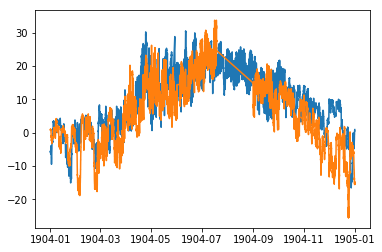

In [105]:
plt.plot(data[data.Year==aasta].Pseudo_date,data[data.Year==aasta].Temperature)
plt.plot(data[data.Year==aasta+1].Pseudo_date,data[data.Year==aasta+1].Temperature)

In [107]:
data[[data.Year==2000] and [data.Month==5]]

ValueError: Item wrong length 1 instead of 1971677.

# Some tests...

In [100]:
%matplotlib qt
# kuvab matplotlib graafikud eraldi aknas

In [73]:
%matplotlib inline
# kuvab graafikud töölehel

In [74]:
data['2008']

,Temperature,Pseudo_date,Year,Month,Day
Times,,,,,
2008-01-01 00:00:00,-2.1984,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:05:00,-2.1992,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:10:00,-2.1769,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:15:00,-2.2000,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:20:00,-2.2000,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:25:00,-2.1968,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:30:00,-2.1931,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:35:00,-2.2000,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:40:00,-2.1089,1904-01-01 00:00:00,2008,1,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a259b0f28>,
      dtype=object)

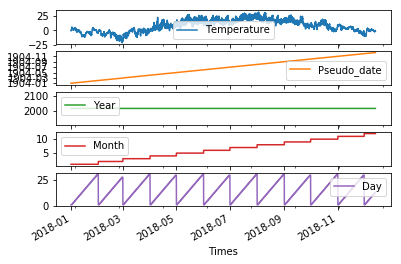

In [75]:
data['2018'].plot(subplots=True)


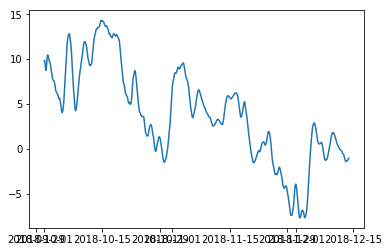

In [79]:
plt.plot(data['2018-10':].Temperature.resample('H').mean().rolling('1D').mean())

In [81]:
data['Pseudo_date']=data.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)

In [80]:
data['2017-02-28 20:10:00'].Pseudo_date

Times
2017-02-28 20:10:00   1904-02-28 20:00:00
Name: Pseudo_date, dtype: datetime64[ns]

In [81]:
graafikud=data['2017']
graafikud=graafikud.rename(columns={'Temperature':'2017'})
graafikud.drop(graafikud.columns[1:], axis=1, inplace=True)
graafikud=graafikud.resample('H').mean()

graafikud['Pseudo_date']=graafikud.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
graafikud=graafikud.set_index('Pseudo_date')

In [82]:
graafikud=data['2017']
graafikud=graafikud.rename(columns={'Temperature':'2017'})
graafikud.drop(graafikud.columns[1:], axis=1, inplace=True)
graafikud=graafikud.resample('H').mean()

graafikud['Pseudo_date']=graafikud.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
graafikud=graafikud.set_index('Pseudo_date')

graafikud2=data['2018']
graafikud2=graafikud2.rename(columns={'Temperature':'2018'})
graafikud2.drop(graafikud2.columns[1:], axis=1, inplace=True)
graafikud2=graafikud2.resample('H').mean()
graafikud2['Pseudo_date']=graafikud2.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
graafikud2=graafikud2.set_index('Pseudo_date')

graafikud3=data['2016']
graafikud3=graafikud3.rename(columns={'Temperature':'2016'})
graafikud3.drop(graafikud3.columns[1:], axis=1, inplace=True)
graafikud3=graafikud3.resample('H').mean()
graafikud3['Pseudo_date']=graafikud3.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
graafikud3=graafikud3.set_index('Pseudo_date')

graafikud=pd.concat([graafikud,graafikud2,graafikud3], axis=1)

In [83]:
graafikud.head(15)

,2017,2018,2016
Pseudo_date,,,
1904-01-01 00:00:00,5.7483,-0.5061,-7.0874
1904-01-01 01:00:00,5.7213,-0.3747,-7.2492
1904-01-01 02:00:00,5.6972,-0.2104,-7.6005
1904-01-01 03:00:00,5.5821,-0.0056,-7.9606
1904-01-01 04:00:00,5.4056,0.0713,-8.3057
1904-01-01 05:00:00,5.2922,0.3020,-8.4601
1904-01-01 06:00:00,5.1809,0.2085,-8.3749
1904-01-01 07:00:00,5.1506,0.2526,-8.5294
1904-01-01 08:00:00,5.0560,0.4392,-8.8453


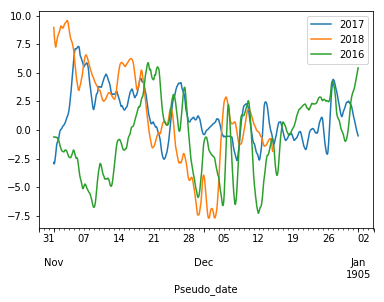

In [88]:

graafikud['1904-11':].rolling('1D').mean().plot()

In [89]:
graafikud.Temperature.rolling('7D').mean().plot()

AttributeError: 'DataFrame' object has no attribute 'Temperature'

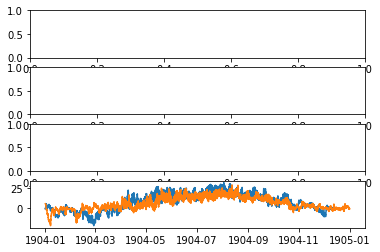

In [90]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax2=plt.plot(data['2018'].Pseudo_date, data['2018'].Temperature)
ax0=plt.plot(data['2017'].Pseudo_date, data['2017'].Temperature)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a24b63d30>,
      dtype=object)

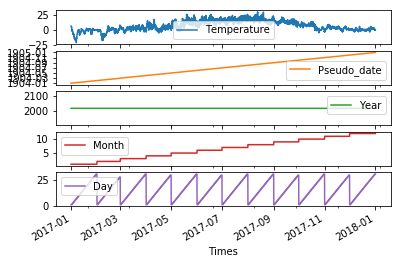

In [91]:
data['2017'].plot(subplots=True)

In [92]:
data['2018'].index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:05:00',
               '2018-01-01 00:10:00', '2018-01-01 00:15:00',
               '2018-01-01 00:20:00', '2018-01-01 00:25:00',
               '2018-01-01 00:30:00', '2018-01-01 00:35:00',
               '2018-01-01 00:40:00', '2018-01-01 00:45:00',
               ...
               '2018-12-13 20:25:00', '2018-12-13 20:30:00',
               '2018-12-13 20:35:00', '2018-12-13 20:40:00',
               '2018-12-13 20:45:00', '2018-12-13 20:50:00',
               '2018-12-13 20:55:00', '2018-12-13 21:00:00',
               '2018-12-13 21:05:00', '2018-12-13 21:10:00'],
              dtype='datetime64[ns]', name='Times', length=100723, freq=None)

viide: https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

In [93]:
#plt.figure(figsize=(12,5))
fig, ax = plt.subplots(1, sharey=True)
data['2017'].plot(ax=ax)
data['2018'].asfreq('5min').tshift(-60/5*24*365).plot(ax=ax)

#plt.plot(data['2018'].index,data['2018'])

ValueError: view limit minimum -34793.82541004417 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x120c17f28> (for post_execute):


ValueError: view limit minimum -34793.82541004417 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -34793.82541004417 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [75]:
#data=data.asfreq('5min')
data=data.asfreq('1W')

ValueError: cannot reindex from a duplicate axis

In [94]:
data.head(10)

,Temperature,Pseudo_date,Year,Month,Day
Times,,,,,
1999-11-01 00:00:00,6.6000,1904-11-01,1999,11,1
1999-11-01 00:05:00,6.6000,1904-11-01,1999,11,1
1999-11-01 00:10:00,6.5000,1904-11-01,1999,11,1
1999-11-01 00:15:00,6.6000,1904-11-01,1999,11,1
1999-11-01 00:20:00,6.6000,1904-11-01,1999,11,1
1999-11-01 00:25:00,6.7000,1904-11-01,1999,11,1
1999-11-01 00:30:00,6.7000,1904-11-01,1999,11,1
1999-11-01 00:35:00,6.7000,1904-11-01,1999,11,1
1999-11-01 00:40:00,6.7000,1904-11-01,1999,11,1


In [133]:
#plt.show()

***
### Proovime võtteid Datacamp-kursusest Importing and Managing Financial Data in Python
ch3.pdf

In [95]:
%%time
data=pd.read_pickle("data.pkl")
#data.drop(data.columns[1:], axis=1, inplace=True)

CPU times: user 116 ms, sys: 504 ms, total: 619 ms
Wall time: 950 ms


%%time
#### add column called Pseudo_date for easier data grouping and plotting
data['Pseudo_date']=data.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day), axis=1)
data['Year']=data.index.year
data['Month']=data.index.month
data['Day']=data.index.day

In [96]:
data.head()

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
1999-11-01 00:00:00,6.6000,nan,1001.7000,1.1000,227.0000,nan,nan,0.0000,nan,0.0920,nan
1999-11-01 00:05:00,6.6000,nan,1001.5000,1.2000,230.0000,nan,nan,0.0000,nan,0.0900,nan
1999-11-01 00:10:00,6.5000,nan,1001.2000,0.5000,203.0000,nan,nan,0.0000,nan,0.1030,nan
1999-11-01 00:15:00,6.6000,nan,1001.6000,0.8000,223.0000,nan,nan,0.0000,nan,0.0630,nan
1999-11-01 00:20:00,6.6000,nan,1001.7000,1.3000,243.0000,nan,nan,0.0000,nan,0.1010,nan


In [97]:
data[data.index==data.Temperature.idxmax()]

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
2001-07-16 13:20:00,33.7000,73.9000,1004.9000,1.8000,243.0000,nan,nan,33250.0000,383.0000,0.1250,nan


In [80]:
data.Temperature.mean()

6.633690660112848

In [81]:
data.Temperature.median()

6.327346551957129

In [82]:
data.Temperature.mode()

0   0.0000
dtype: float64

In [83]:
data.Temperature.var()

90.04879958018567

In [84]:
data.Temperature.std()

9.48940459566277

In [85]:
np.sqrt(data.Temperature.var())==data.Temperature.std()

True

Quantiles: 
* Quartiles (4 groups, each 25% of data) 
* Deciles (10 groups, each 10% of data)
* Interquartile range


In [86]:
data.quantile(.5) #==data.median()

Temperature            6.3273
Humidity              83.3228
Air_pressure        1007.6194
Wind_speed             2.4403
Wind_direction       202.7875
Precipitation          0.0000
UV_index               0.6271
Light               1965.4513
Irradiation_flux       5.5060
Gamma_radiation        0.0967
Snowfall_estimate      0.0000
Name: 0.5, dtype: float64

In [87]:
deciles=np.arange(start=0.1, stop=0.91, step=0.1)
deciles

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [88]:
data.Temperature.quantile(deciles)

0.1000   -5.1412
0.2000   -1.0000
0.3000    1.0776
0.4000    3.4155
0.5000    6.3273
0.6000    9.7000
0.7000   12.7314
0.8000   15.5000
0.9000   18.8310
Name: Temperature, dtype: float64

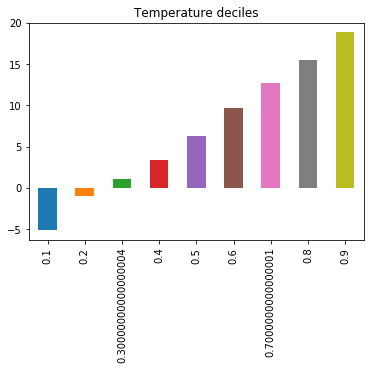

In [89]:
data.Temperature.quantile(deciles).plot(kind='bar',title='Temperature deciles')
#plt.tight_layout()

In [90]:
data.Temperature.describe()

count   1955052.0000
mean          6.6337
std           9.4894
min        -131.8409
25%           0.1183
50%           6.3273
75%          14.1000
max          33.7000
Name: Temperature, dtype: float64

In [91]:
data.Temperature.describe(percentiles=np.arange(0.1,0.91,0.1))

count   1955052.0000
mean          6.6337
std           9.4894
min        -131.8409
10%          -5.1412
20%          -1.0000
30.0%         1.0776
40%           3.4155
50%           6.3273
60%           9.7000
70%          12.7314
80%          15.5000
90%          18.8310
max          33.7000
Name: Temperature, dtype: float64

ch3-video3.mp4
seaborn.distplot()
* histogram
* kernel density estimation (KDE)
* Rugplot

.dropna()
.fillna()

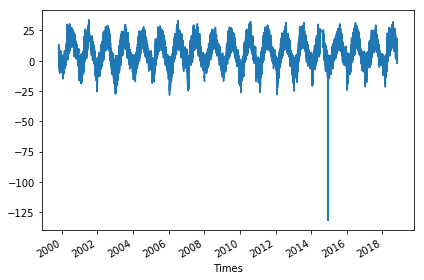

In [92]:
data.Temperature.dropna(inplace=True)
data.Temperature.plot(); plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


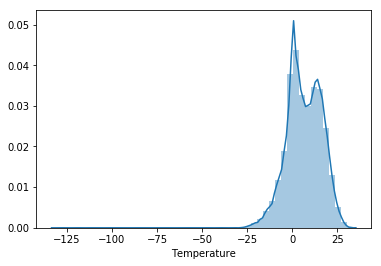

In [93]:
sns.distplot(data.Temperature)

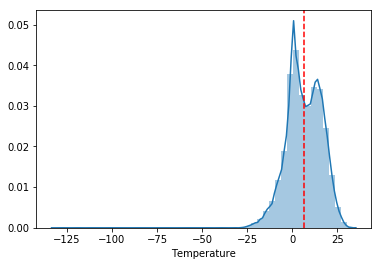

In [94]:
ax=sns.distplot(data.Temperature)
ax.axvline(data.Temperature.median(),color='red',ls='--')

ch3-video4.mp4 "Summarize categorical variables"
<br>quantitative variables vs categorical variables
<br>Instead of "average" and "median" we use frequency distribution.
<br>Columns with numeric data can also represent categoris. IPO year for instance. Or wind direction?
<br>
<br>pandas .nunique() - returns number of different values
<br>pandas .unique() - returns unique values
<br>
<br>function: .applay() - one column of a time!
<br>anonymouse function data.apply(lambda x: x.nunique()) 
<br>lambda: “anonymous function”, receives each column as argument x
<br>
<br>pandas .value_counts()

In [95]:
data.columns.nunique()

11

In [96]:
#how many unique values there are in each column
data.apply(lambda x: x.nunique())

Temperature          1128900
Humidity             1055561
Air_pressure         1080804
Wind_speed            789176
Wind_direction        789280
Precipitation           2331
UV_index              266190
Light                 617069
Irradiation_flux      318494
Gamma_radiation       777819
Snowfall_estimate        102
dtype: int64

In [97]:
data.Wind_direction.value_counts()


0.0000      4700
229.0000    3039
231.0000    2974
230.0000    2970
151.0000    2942
145.0000    2934
142.0000    2933
152.0000    2913
150.0000    2891
144.0000    2873
143.0000    2865
147.0000    2855
228.0000    2814
149.0000    2798
153.0000    2797
146.0000    2790
148.0000    2786
275.0000    2747
257.0000    2747
175.0000    2745
274.0000    2735
154.0000    2729
272.0000    2729
256.0000    2720
232.0000    2717
157.0000    2715
155.0000    2708
273.0000    2698
140.0000    2684
213.0000    2678
            ... 
275.1614       1
313.4934       1
196.5249       1
291.6238       1
246.5553       1
275.9688       1
229.1394       1
220.1717       1
278.4587       1
12.8518        1
252.3731       1
102.6310       1
44.3917        1
280.6343       1
243.6964       1
347.1980       1
278.0902       1
127.9193       1
103.9495       1
292.1775       1
126.1686       1
182.1001       1
243.5219       1
76.1749        1
27.3234        1
40.5878        1
16.1193        1
100.2013      

In [98]:
#how many measurements per year
data.index.year.value_counts()


2016    105398
2004    105387
2012    105174
2017    105121
2005    105100
2009    105081
2008    105057
2013    105043
2006    105003
2010    104942
2007    104906
2011    104874
2015    104695
2003    104678
2002    104264
2000    100137
2001     90905
2014     87607
2018     87025
1999     17461
Name: Times, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

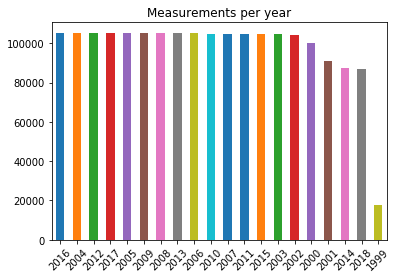

In [99]:
data.index.year.value_counts().plot(kind='bar', title='Measurements per year')
plt.xticks(rotation=45)

Ch4-video1.mp4 "Aggregate your data by category"

describing individual variables -> split data into groups and describe group statistics


In [100]:
data['Year']=data.index.year
data['Month']=data.index.month
data['Day']=data.index.day

In [101]:
data2=data.groupby('Year')

In [102]:
for year, data3 in data2:
    print(year, data3.Temperature.max())

1999 13.3
2000 30.5
2001 33.7
2002 29.3
2003 29.9
2004 28.1
2005 28.8
2006 33.3
2007 30.577327935222698
2008 27.3999999999999
2009 27.731679521634398
2010 32.4742844095636
2011 29.382056234551396
2012 31.727498785801398
2013 31.6163530844
2014 30.1496337649
2015 30.4612893983
2016 31.3848295455
2017 29.3503428571
2018 32.1910773481


In [103]:
data2.Temperature.max()

Year
1999   13.3000
2000   30.5000
2001   33.7000
2002   29.3000
2003   29.9000
2004   28.1000
2005   28.8000
2006   33.3000
2007   30.5773
2008   27.4000
2009   27.7317
2010   32.4743
2011   29.3821
2012   31.7275
2013   31.6164
2014   30.1496
2015   30.4613
2016   31.3848
2017   29.3503
2018   32.1911
Name: Temperature, dtype: float64

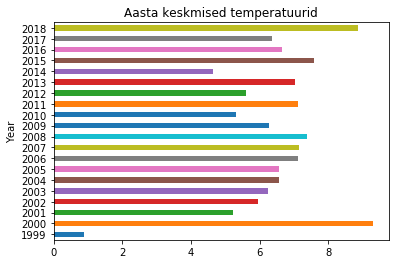

In [104]:
data2.Temperature.mean().plot(kind='barh', title='Aasta keskmised temperatuurid')

In [105]:
data2.mean()

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate,Month,Day
Year,,,,,,,,,,,,,
1999,0.8946,nan,1003.8259,1.9810,196.5993,nan,nan,2370.1962,nan,0.1058,nan,11.5113,15.6763
2000,9.2922,87.3727,1007.5969,1.9778,195.1023,nan,nan,11140.0373,146.7000,0.1034,nan,6.4725,15.8583
2001,5.2268,81.0598,1003.6528,2.0567,195.4264,nan,nan,10528.3720,119.7762,0.1022,nan,6.3576,15.4682
2002,5.9598,70.4251,1002.9049,2.2442,183.2559,0.0027,nan,14809.2346,108.9409,0.0994,0.0106,6.4894,15.7398
2003,6.2543,76.9286,1005.2562,1.9590,194.6778,0.0044,nan,11030.6172,106.4701,0.1003,0.0039,6.5348,15.6894
2004,6.5514,78.1754,1004.8746,1.7645,175.4442,0.0038,nan,9573.3528,135.7080,0.1012,0.0017,6.5139,15.7546
2005,6.5669,77.9725,1006.4988,1.8067,170.2293,0.0039,nan,9471.9896,93.1532,0.1009,0.0013,6.5263,15.7190
2006,7.1175,75.4534,1006.4019,1.9601,167.9575,0.0027,nan,13503.4624,149.6931,0.1011,0.0020,6.5244,15.7249
2007,7.1366,76.0590,1012.1834,3.0981,185.8676,0.0041,0.7568,13508.8459,62.1333,0.0962,0.0031,6.5331,15.7412


ch4 video2.mp4 "More ways to aggregate your data"
In practice you need to group by more than one column


In [106]:
data2.Temperature.agg(['mean', 'min', 'max','std'])

,mean,min,max,std
Year,,,,
1999,0.8946,-10.5000,13.3000,4.7441
2000,9.2922,-16.6000,30.5000,8.6824
2001,5.2268,-25.6000,33.7000,9.9149
2002,5.9598,-24.2000,29.3000,10.0625
2003,6.2543,-27.5000,29.9000,9.5256
2004,6.5514,-17.2000,28.1000,8.7821
2005,6.5669,-18.6000,28.8000,9.5656
2006,7.1175,-28.4000,33.3000,10.3363
2007,7.1366,-24.8000,30.5773,9.5735


In [107]:
data2.Temperature.agg({'Keskmine':'mean','Miinimum':'min', 'Maksimum':'max','Standardhälve':'std'})

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,Keskmine,Miinimum,Maksimum,Standardhälve
Year,,,,
1999,0.8946,-10.5000,13.3000,4.7441
2000,9.2922,-16.6000,30.5000,8.6824
2001,5.2268,-25.6000,33.7000,9.9149
2002,5.9598,-24.2000,29.3000,10.0625
2003,6.2543,-27.5000,29.9000,9.5256
2004,6.5514,-17.2000,28.1000,8.7821
2005,6.5669,-18.6000,28.8000,9.5656
2006,7.1175,-28.4000,33.3000,10.3363
2007,7.1366,-24.8000,30.5773,9.5735


In [108]:
data2.agg({'Temperature':'mean','Precipitation':'sum','Wind_speed':'mean'})

,Temperature,Precipitation,Wind_speed
Year,,,
1999,0.8946,0.0000,1.9810
2000,9.2922,0.0000,1.9778
2001,5.2268,0.0000,2.0567
2002,5.9598,141.6000,2.2442
2003,6.2543,460.0000,1.9590
2004,6.5514,400.6000,1.7645
2005,6.5669,411.6000,1.8067
2006,7.1175,277.2000,1.9601
2007,7.1366,422.6000,3.0981


In [109]:
data3=data.groupby(['Year','Month'])

In [110]:
data3.Temperature.mean()

Year  Month
1999  11       2.0596
      12      -0.2260
2000  1       -1.8331
      2        0.2421
      3        2.0353
      4       12.0113
      5       13.8154
      6       17.7279
      7       19.4261
      8       18.7925
      9       12.8987
      10      11.1244
      11       5.6578
      12       1.7479
2001  1       -1.2493
      2       -4.6090
      3       -1.3450
      4        8.7207
      5       12.0745
      6       16.4857
      7       23.0555
      8       11.9679
      9       11.7402
      10       8.1633
      11      -0.0633
      12      -7.8241
2002  1       -3.1913
      2       -0.5574
      3        0.9738
      4        6.2488
                ...  
2016  5       15.1207
      6       16.5643
      7       18.4259
      8       16.4766
      9       12.9001
      10       4.2085
      11      -0.9316
      12      -0.2734
2017  1       -3.5041
      2       -2.9749
      3        1.4416
      4        3.4338
      5       10.3479
      6       13.950

In [111]:
grouped_temp=data3.Temperature.mean()

In [112]:
grouped_temp.loc[[2000,2012]]

Year  Month
2000  1       -1.8331
      2        0.2421
      3        2.0353
      4       12.0113
      5       13.8154
      6       17.7279
      7       19.4261
      8       18.7925
      9       12.8987
      10      11.1244
      11       5.6578
      12       1.7479
2012  1       -4.8184
      2       -9.9274
      3        0.2451
      4        5.1862
      5       12.3286
      6       14.3522
      7       18.6714
      8       15.5312
      9       12.4114
      10       6.1710
      11       2.9964
      12      -6.2022
Name: Temperature, dtype: float64

ch4 video3.mp4 "Summary statistics by category with seaborn"

Seaborn combineds plotting categorical and numerical cariables
* countplot


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

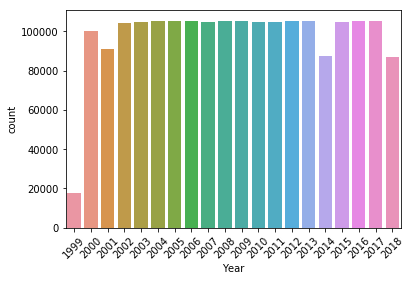

In [113]:
sns.countplot(x='Year', data=data)
plt.xticks(rotation=45)

In [114]:
#sorted list plotting
data2=data.groupby('Year').size()
order=data2.sort_values(ascending=False)
order

Year
2016    105398
2004    105387
2012    105174
2017    105121
2005    105100
2009    105081
2008    105057
2013    105043
2006    105003
2010    104942
2007    104906
2011    104874
2015    104695
2003    104678
2002    104264
2000    100137
2001     90905
2014     87607
2018     87025
1999     17461
dtype: int64

In [115]:
order=order.index.tolist()
order

[2016,
 2004,
 2012,
 2017,
 2005,
 2009,
 2008,
 2013,
 2006,
 2010,
 2007,
 2011,
 2015,
 2003,
 2002,
 2000,
 2001,
 2014,
 2018,
 1999]

Text(0.5, 1.0, '# of measurements per year')

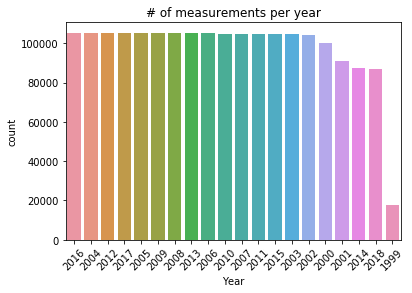

In [116]:
sns.countplot(x='Year', data=data, order=order)
plt.xticks(rotation=45)
plt.title('# of measurements per year')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

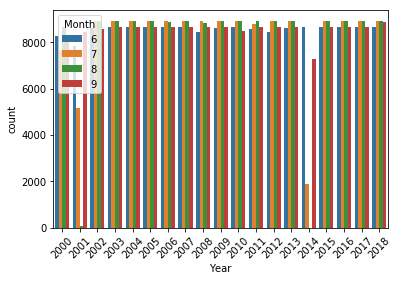

In [117]:
sns.countplot(x='Year', hue='Month', data=data[data['Month'].isin([6,7,8,9])])
plt.xticks(rotation=45)

CPU times: user 21.4 s, sys: 636 ms, total: 22 s
Wall time: 22 s


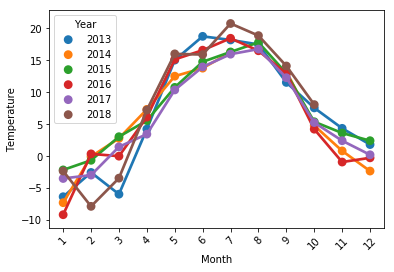

In [118]:
%%time
# Seaborn pointplot
sns.pointplot(x='Month', y='Temperature', hue='Year', data=data[data.Year.isin([2018,2017,2016,2015,2014,2013])])
plt.xticks(rotation=45)

CPU times: user 21 s, sys: 666 ms, total: 21.7 s
Wall time: 21.8 s


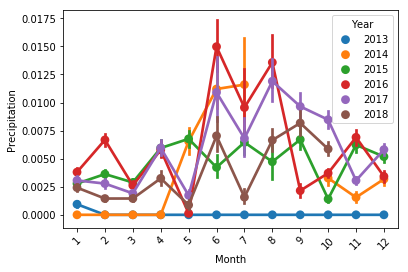

In [125]:
%%time
# Seaborn pointplot
sns.pointplot(x='Month', y='Precipitation', hue='Year', data=data[data.Year.isin([2018,2017,2016,2015,2014,2013])])
plt.xticks(rotation=45)

ch4 video4.mp4 "Distributions by category with seaborn"
visualize distribution of a variable by levels of a categorical variable to facilitate comparison


In [126]:
# remove outliers
outliers_l=data.Temperature.quantile(0.0001)
outliers_h=data.Temperature.quantile(0.995)
print(outliers_l, ';',outliers_h)

-27.0 ; 27.114163795373607


In [127]:
data=data[(data.Temperature > outliers_l)]
#data=data[(data.Temperature < outliers_h)]

In [128]:
len(data)

1954835

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

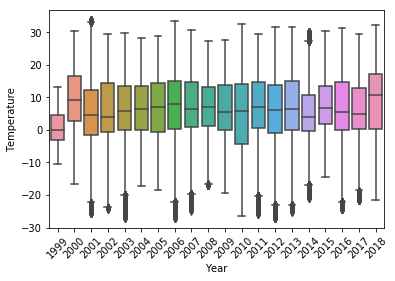

In [129]:
sns.boxplot(x='Year', y='Temperature',data=data)
plt.xticks(rotation=45)

as we have limited number of data for 2018, lets drop 'years-end' datapoints also from other years to get comparable results.
We still have problems with years 2014 and 2001 where some data from sommer months is missing (take a look at countplot graph).


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

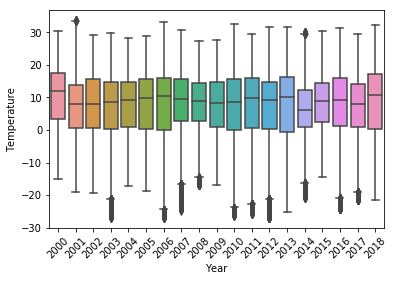

In [132]:
sns.boxplot(x='Year', y='Temperature',data=data[data.Month<11])
plt.xticks(rotation=45)

CPU times: user 8.1 s, sys: 1.07 s, total: 9.17 s
Wall time: 9.58 s


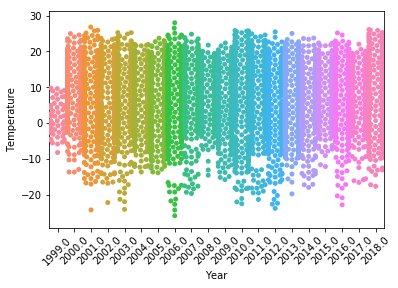

In [133]:
%%time
#SwarmPlot
sns.swarmplot(x='Year',y='Temperature',data=data.resample('D').mean()) #resample to D or W is OK. to H it is to much data still
plt.xticks(rotation=45)

***

***
### Datacamp kursus Manipulating Time Series Data in Python

Chapter11.pdf

In [203]:
%%time
data=pd.read_pickle("data.pkl")
#data.drop(data.columns[1:], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1951797 entries, 1999-11-01 00:00:00 to 2018-10-08 07:50:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 178.7 MB
Wall time: 220 ms


In [532]:
index=pd.date_range('2018-1-1','2018-12-31',freq='W')
index

DatetimeIndex(['2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28',
               '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25',
               '2018-03-04', '2018-03-11', '2018-03-18', '2018-03-25',
               '2018-04-01', '2018-04-08', '2018-04-15', '2018-04-22',
               '2018-04-29', '2018-05-06', '2018-05-13', '2018-05-20',
               '2018-05-27', '2018-06-03', '2018-06-10', '2018-06-17',
               '2018-06-24', '2018-07-01', '2018-07-08', '2018-07-15',
               '2018-07-22', '2018-07-29', '2018-08-05', '2018-08-12',
               '2018-08-19', '2018-08-26', '2018-09-02', '2018-09-09',
               '2018-09-16', '2018-09-23', '2018-09-30', '2018-10-07',
               '2018-10-14', '2018-10-21', '2018-10-28', '2018-11-04',
               '2018-11-11', '2018-11-18', '2018-11-25', '2018-12-02',
               '2018-12-09', '2018-12-16', '2018-12-23', '2018-12-30'],
              dtype='datetime64[ns]', freq='W-SUN')

In [533]:
pd.DataFrame({'data':index}).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 1 columns):
data    52 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 496.0 bytes


# Leiame sobiliku aja puhkuseks
Kriteeriumid:
1. kõrgeim perioodi temp (keskmine)
2. kõige vähem sademeid (summa)
3. madalaim tuule kiirus? (keskmine)

In [56]:
periood=14

 peaks lõikuma Aeg veeru järgi df'i 14-päevasteks lõikudeks ja sealt võtma vajaliku statistika
 kasulik: https://chrisalbon.com/python/data_wrangling/pandas_time_series_basics/ 

 võtame uueks index'iks Aeg tulba ja kustutame eraldi Aeg tulba
<br>
data.index=data['Aeg']
<br>
del data['Aeg']

In [43]:
data['2014-05-01']

,Temperature
Times,
2014-05-01 00:00:00,6.1807
2014-05-01 00:05:00,6.0750
2014-05-01 00:10:00,6.0008
2014-05-01 00:15:00,5.9552
2014-05-01 00:20:00,5.8900
2014-05-01 00:25:00,5.7879
2014-05-01 00:30:00,5.6834
2014-05-01 00:35:00,5.5821
2014-05-01 00:40:00,5.4549


In [61]:
data['2014-05']['Sademed'].resample('D').sum()

Aeg
2014-05-01     0.0
2014-05-02     0.0
2014-05-03     0.0
2014-05-04     0.0
2014-05-05     0.0
2014-05-06     0.0
2014-05-07     0.0
2014-05-08     0.0
2014-05-09     1.8
2014-05-10     5.6
2014-05-11     1.6
2014-05-12     3.2
2014-05-13    20.6
2014-05-14     0.0
2014-05-15     0.0
2014-05-16     0.0
2014-05-17     0.0
2014-05-18     0.0
2014-05-19     0.0
2014-05-20    12.6
2014-05-21     5.6
2014-05-22     0.2
2014-05-23     0.0
2014-05-24     0.0
2014-05-25     6.6
2014-05-26     0.0
2014-05-27     0.0
2014-05-28     0.0
2014-05-29     0.4
2014-05-30     0.0
2014-05-31     0.0
Freq: D, Name: Sademed, dtype: float64

In [44]:
data['2014-05']['Temperature'].resample('D').mean()

Times
2014-05-01    4.3881
2014-05-02    4.5120
2014-05-03    5.1417
2014-05-04    5.7198
2014-05-05    3.2571
2014-05-06    4.1559
2014-05-07    6.0856
2014-05-08   10.2245
2014-05-09   12.3871
2014-05-10   13.0770
2014-05-11   10.6085
2014-05-12   11.4975
2014-05-13    8.8762
2014-05-14    9.8765
2014-05-15   10.2058
2014-05-16   11.5481
2014-05-17   14.8982
2014-05-18   19.0559
2014-05-19   23.7270
2014-05-20   21.7730
2014-05-21   16.9213
2014-05-22   18.6190
2014-05-23   21.5857
2014-05-24   23.6022
2014-05-25   23.3690
2014-05-26   19.9044
2014-05-27    9.8067
2014-05-28    7.1782
2014-05-29    9.9302
2014-05-30   11.4209
2014-05-31   14.0363
Freq: D, Name: Temperature, dtype: float64

In [63]:
# loome uue dataframe'i statistika jaoks stat
# peaks tegema nii, et andmeväljadeks oleks 
# 1. Aeg, 
# 2. sellest päeva keskmine temp, 
# 3. päeva sum sademeid, 
# 4. päeva keskmine tuulekiirus


In [21]:
#stat=pd.DataFrame(data[:]['Tuule kiirus'].resample('D').mean())
stat=pd.DataFrame()

In [22]:
#stat.columns=['Keskmine tuule kiirus']

In [23]:
stat['Keskmine temperatuur']=(data[:]['Temperature'].resample('D').mean())


In [24]:
#stat['Sademeid']=data[:]['Sademed'].resample('D').sum()

In [25]:
stat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6910 entries, 1999-11-01 to 2018-10-01
Freq: D
Data columns (total 1 columns):
Keskmine temperatuur    6795 non-null float64
dtypes: float64(1)
memory usage: 108.0 KB


In [27]:
stat.tail(15)

,Keskmine temperatuur
Times,
2018-09-17,11.7617
2018-09-18,14.0505
2018-09-19,18.3861
2018-09-20,17.2014
2018-09-21,19.3696
2018-09-22,14.7670
2018-09-23,9.7189
2018-09-24,8.2830
2018-09-25,6.3873


In [72]:
# loome uue dataframe'i statistika jaoks stat2
# peks tegema nii, et andmeväljadeks oleks 
# 1. Aeg, 
# 2. sellest päevast (kaasa arvatud) perioodi keskmine temp, 
# 3. perioodi sum sademeid, 
# 4. perioodi keskmine tuulekiirus

#stat2=pd.DataFrame()

In [76]:
periood=35

In [77]:
#lõikan eraldi muutjuasse kõik indexid kuni viimase perioodi alguseni
#eemaldan väärtused
stat2=stat[0:-periood+1].copy()
#stat2['Keskmine tuule kiirus']='NaN'
stat2['Keskmine temperatuur']='NaN'
#stat2['Sademeid']='NaN'

In [78]:
periood

35

In [79]:
stat2

,Keskmine temperatuur
Times,
1999-11-01,NaN
1999-11-02,NaN
1999-11-03,NaN
1999-11-04,NaN
1999-11-05,NaN
1999-11-06,NaN
1999-11-07,NaN
1999-11-08,NaN
1999-11-09,NaN


In [80]:
%%time
for paev in stat2.index:
    stat2.loc[paev]['Keskmine temperatuur']=stat[paev:paev+periood]['Keskmine temperatuur'].mean()
    #stat2.loc[paev]['Sademeid']=stat[paev:paev+periood]['Sademeid'].sum()
    #stat2.loc[paev]['Keskmine tuule kiirus']=stat[paev:paev+periood]['Keskmine tuule kiirus'].mean()
    

Wall time: 2.77 s


In [81]:
%%time
for element in stat2.columns:
    print(element)
    stat2[element]=pd.to_numeric(stat2[element],errors='coerce')

Keskmine temperatuur
Wall time: 0 ns


In [82]:
stat2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6876 entries, 1999-11-01 to 2018-08-28
Freq: D
Data columns (total 1 columns):
Keskmine temperatuur    6844 non-null float64
dtypes: float64(1)
memory usage: 427.4 KB


In [83]:
stat2.tail(14)

,Keskmine temperatuur
Times,
2018-08-15,16.7214
2018-08-16,16.7515
2018-08-17,16.7928
2018-08-18,16.6604
2018-08-19,16.3184
2018-08-20,16.0382
2018-08-21,15.7635
2018-08-22,15.5680
2018-08-23,15.4670


In [84]:
stat2.tail(1)

,Keskmine temperatuur
Times,
2018-08-28,14.3157


Siit kontrollides keskmiste ja summade arvutus töötab õigesti.

Leiame nüüd iga aasta parimad perioodid stat2-st

In [39]:
stat2['2018']['Keskmine temperatuur'].idxmax()

Timestamp('2018-07-20 00:00:00', freq='D')

In [41]:
stat2[str(2014)]['Keskmine temperatuur'].idxmax()

Timestamp('2014-07-07 00:00:00', freq='D')

In [42]:
stat2.loc['2016-07-01']

Keskmine temperatuur   17.1926
Name: 2016-07-01 00:00:00, dtype: float64

Timestamp('2000-07-05 00:00:00', freq='D')

In [85]:
# vaatame, iga aasta soojeima perioodi alguse kuupäeva
print('Puhkuseprioodi pikkus:',periood)
for aasta in range(2000,2019):
    print(aasta, " :",stat2[str(aasta)]['Keskmine temperatuur'].idxmax())

Puhkuseprioodi pikkus: 35
2000  : 2000-06-21 00:00:00
2001  : 2001-07-18 00:00:00
2002  : 2002-07-11 00:00:00
2003  : 2003-07-01 00:00:00
2004  : 2004-07-18 00:00:00
2005  : 2005-07-04 00:00:00
2006  : 2006-06-13 00:00:00
2007  : 2007-07-22 00:00:00
2008  : 2008-07-14 00:00:00
2009  : 2009-07-08 00:00:00
2010  : 2010-07-05 00:00:00
2011  : 2011-06-27 00:00:00
2012  : 2012-07-01 00:00:00
2013  : 2013-06-01 00:00:00
2014  : 2014-07-07 00:00:00
2015  : 2015-07-24 00:00:00
2016  : 2016-06-24 00:00:00
2017  : 2017-07-16 00:00:00
2018  : 2018-07-07 00:00:00


In [88]:
#
%matplotlib qt
#%matplotlib inline

In [86]:
stat3=pd.DataFrame()
puhkuselist=[]

In [99]:
#stat2['2000']['Keskmine temperatuur'].plot(ax=ax)
#stat2['2002']['Keskmine temperatuur'].plot()#(ax=ax)

fig, ax = plt.subplots(1, sharey=True)
nihe=0
for aasta in range(2000,2019):
#    stat2[str(aasta)]['Keskmine temperatuur'].plot(ax=ax)#.tshift(-365*nihe).plot(ax=ax)
    stat2[str(aasta)]['Keskmine temperatuur'].tshift(-365*nihe).plot(ax=ax)
    puhkus=stat2[str(aasta)].idxmax().tolist()[0]
#    ax.axvspan(puhkus, puhkus+datetime.timedelta(days=periood), color='red', alpha=0.3)
    ax.axvspan(puhkus-datetime.timedelta(days=365*nihe), puhkus+datetime.timedelta(days=periood)-datetime.timedelta(days=365*nihe), color='red', alpha=0.1)
    nihe+=1
    print(aasta, '-', puhkus)
    puhkuselist.append(puhkus)
#    stat2['2001']['Keskmine temperatuur'].tshift(-365).plot(ax=ax)

2000 - 2000-06-21 00:00:00
2001 - 2001-07-18 00:00:00
2002 - 2002-07-11 00:00:00
2003 - 2003-07-01 00:00:00
2004 - 2004-07-18 00:00:00
2005 - 2005-07-04 00:00:00
2006 - 2006-06-13 00:00:00
2007 - 2007-07-22 00:00:00
2008 - 2008-07-14 00:00:00
2009 - 2009-07-08 00:00:00
2010 - 2010-07-05 00:00:00
2011 - 2011-06-27 00:00:00
2012 - 2012-07-01 00:00:00
2013 - 2013-06-01 00:00:00
2014 - 2014-07-07 00:00:00
2015 - 2015-07-24 00:00:00
2016 - 2016-06-24 00:00:00
2017 - 2017-07-16 00:00:00
2018 - 2018-07-07 00:00:00


ValueError: Cannot add integral value to Timestamp without freq.

In [97]:
print(puhkuselist[3].year-2000)
puhkuselist[1]-datetime.timedelta(weeks=52)

3


Timestamp('2000-07-19 00:00:00')

In [117]:
puhkuselist2=[]
for i in range(len(puhkuselist)):
#    print(i)
    puhkuselist2.append(puhkuselist[i]-datetime.timedelta(weeks=52*i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [118]:
puhkuselist2

[Timestamp('2000-07-05 00:00:00'),
 Timestamp('2000-07-19 00:00:00'),
 Timestamp('2000-07-13 00:00:00'),
 Timestamp('2000-07-17 00:00:00'),
 Timestamp('2000-07-24 00:00:00'),
 Timestamp('2000-07-10 00:00:00'),
 Timestamp('2000-06-27 00:00:00'),
 Timestamp('2000-08-12 00:00:00'),
 Timestamp('2000-07-21 00:00:00'),
 Timestamp('2000-07-21 00:00:00'),
 Timestamp('2000-07-19 00:00:00'),
 Timestamp('2000-07-20 00:00:00'),
 Timestamp('2000-08-02 00:00:00'),
 Timestamp('2000-07-08 00:00:00'),
 Timestamp('2000-07-24 00:00:00'),
 Timestamp('2000-08-23 00:00:00'),
 Timestamp('2000-08-01 00:00:00'),
 Timestamp('2000-08-19 00:00:00'),
 Timestamp('2000-08-04 00:00:00')]

In [120]:
stat3['algus']=puhkuselist
stat3['nihutatud']=puhkuselist2

In [121]:
stat3

,algus,nihutatud
0,2000-07-05,2000-07-05
1,2001-07-18,2000-07-19
2,2002-07-11,2000-07-13
3,2003-07-14,2000-07-17
4,2004-07-19,2000-07-24
5,2005-07-04,2000-07-10
6,2006-06-20,2000-06-27
7,2007-08-04,2000-08-12
8,2008-07-11,2000-07-21
9,2009-07-10,2000-07-21


In [122]:
stat3['nihutatud'].describe()

count                      19
unique                     16
top       2000-07-19 00:00:00
freq                        2
first     2000-06-27 00:00:00
last      2000-08-23 00:00:00
Name: nihutatud, dtype: object

TypeError: ufunc add cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

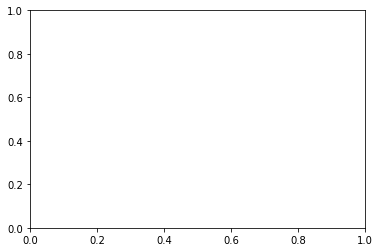

In [123]:
sns.distplot(stat3['nihutatud'])

## Püüaks need aastad nüüd üksteise peale hihutada koos vspan'idega

In [117]:
puhkus=stat2['2018'].idxmax().tolist()[0]

In [108]:
type(puhkus)

pandas._libs.tslibs.timestamps.Timestamp

In [110]:
puhkus

Timestamp('2017-08-05 00:00:00')

In [112]:
puhkus+datetime.timedelta(days=periood)

Timestamp('2017-08-19 00:00:00')

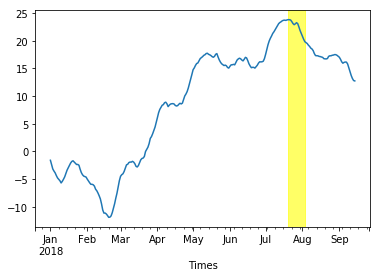

In [118]:
ax=stat2['2018']['Keskmine temperatuur'].plot()
ax.axvspan(puhkus, puhkus+datetime.timedelta(days=periood), color='yellow', alpha=0.6)

AttributeError: 'list' object has no attribute 'mean'

In [101]:
print(range(2000,2019))

range(2000, 2019)


In [49]:
stat2['Sademeid'].idxmin()
#df['Value'].idxmax()

Timestamp('2006-09-21 00:00:00', freq='D')

Kriteeriumid:
1. kõrgeim perioodi temp (keskmine)
2. kõige vähem sademeid (summa)
3. madalaim tuule kiirus? (keskmine)

In [50]:
datetime_object = datetime.strptime('2000', '%Y')

In [51]:
datetime_object

datetime.datetime(2000, 1, 1, 0, 0)

In [52]:
muutuja=pd.Period(2000,'Y')
muutuja

Period('2000', 'A-DEC')

In [53]:
stat2[muutuja]

KeyError: Period('2000', 'A-DEC')

In [199]:
for aasta in range(1999,2018,1):
    print(aasta)
    print(stat2[aasta]['Keskmine temperatuur'].idxmax())

1999


KeyError: 1999

In [210]:
a=stat2['2000']['Keskmine temperatuur'].idxmax()
b=stat2['2000']['Keskmine tuule kiirus'].idxmin()
c=stat2['2000']['Sademeid'].idxmin()

In [211]:
stat2.loc[a]

Keskmine tuule kiirus     2.222083
Keskmine temperatuur     20.378241
Sademeid                  0.000000
Name: 2000-07-11 00:00:00, dtype: float64

In [212]:
stat2.loc[b]

Keskmine tuule kiirus     1.033634
Keskmine temperatuur     11.357500
Sademeid                  0.000000
Name: 2000-09-14 00:00:00, dtype: float64

In [213]:
stat2.loc[c]

Keskmine tuule kiirus    1.683981
Keskmine temperatuur     0.731088
Sademeid                 0.000000
Name: 2000-01-01 00:00:00, dtype: float64

In [24]:
print(stat2['1999']['Keskmine temperatuur'].idxmax())
print(stat2['2000']['Keskmine temperatuur'].idxmax())
print(stat2['2001']['Keskmine temperatuur'].idxmax())
print(stat2['2002']['Keskmine temperatuur'].idxmax())
print(stat2['2003']['Keskmine temperatuur'].idxmax())
print(stat2['2004']['Keskmine temperatuur'].idxmax())
print(stat2['2005']['Keskmine temperatuur'].idxmax())
print(stat2['2006']['Keskmine temperatuur'].idxmax())
print(stat2['2007']['Keskmine temperatuur'].idxmax())
print(stat2['2008']['Keskmine temperatuur'].idxmax())
print(stat2['2009']['Keskmine temperatuur'].idxmax())
print(stat2['2010']['Keskmine temperatuur'].idxmax())
print(stat2['2011']['Keskmine temperatuur'].idxmax())
print(stat2['2012']['Keskmine temperatuur'].idxmax())
print(stat2['2013']['Keskmine temperatuur'].idxmax())
print(stat2['2014']['Keskmine temperatuur'].idxmax())
print(stat2['2015']['Keskmine temperatuur'].idxmax())
print(stat2['2016']['Keskmine temperatuur'].idxmax())
print(stat2['2017']['Keskmine temperatuur'].idxmax())
print(stat2['2018']['Keskmine temperatuur'].idxmax())

1999-11-01 00:00:00
2000-07-11 00:00:00
2001-07-18 00:00:00
2002-07-08 00:00:00
2003-07-20 00:00:00
2004-07-26 00:00:00
2005-07-04 00:00:00
2006-07-01 00:00:00
2007-08-03 00:00:00
2008-07-13 00:00:00
2009-07-15 00:00:00
2010-07-11 00:00:00
2011-07-17 00:00:00
2012-07-24 00:00:00
2013-07-27 00:00:00
2014-07-07 00:00:00
2015-08-02 00:00:00
2016-06-19 00:00:00
2017-08-05 00:00:00
2018-04-05 00:00:00


# edasiseks arenduseks
1. oleks vaja skript saada automatselt andmeid tooma meteo.physic.ut.ee lehelt
2. oleks vaja integreeria PlanetOS andmekogudega

In [11]:
string="http://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D=1999&begin%5Bmon%5D=1&begin%5Bmday%5D=1&end%5Byear%5D=2000&end%5Bmon%5D=1&end%5Bmday%5D=1&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Esita+päring+"
print(string[190:209])
len(string)

4=1&13=1&snow_16=1&


226

In [7]:
from urllib.request import urlopen
fail1=urlopen("http://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D=1999&begin%5Bmon%5D=1&begin%5Bmday%5D=1&end%5Byear%5D=2000&end%5Bmon%5D=1&end%5Bmday%5D=1&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Esita+päring+")

UnicodeEncodeError: 'ascii' codec can't encode character '\xe4' in position 199: ordinal not in range(128)

In [6]:
data=pd.read_csv("http://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D=1999&begin%5Bmon%5D=1&begin%5Bmday%5D=1&end%5Byear%5D=2000&end%5Bmon%5D=1&end%5Bmday%5D=1&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Esita+päring+",encoding='utf-8')

UnicodeEncodeError: 'ascii' codec can't encode character '\xe4' in position 199: ordinal not in range(128)